# Load libraries

In [52]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import seaborn as sns
import pickle
from IPython.display import Image
import itertools
import cv2
# Garbage Collector - use it like gc.collect()
import gc

from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import RMSprop

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define functions

In [53]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        
def visualize_input(img, ax):
  """
  Visualize zoomed in picture
  :param img: Matrix containing image
  :param ax: Ax definition to plot

  :return combs
  """
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
      for y in range(height):
          ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center',
                      color='#00cfcc' if img[x][y]<thresh else '#e6013b')
          
# Draw a confusion matrix that can be used to observe high false positives

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Define parameters

In [54]:
# Define paths
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/Digit Recognizer'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0
np.random.seed(random_state)

# Load data from Kaggle

In [55]:
# Install kaggle
!pip -q install kaggle

# Upload the JSON file downloaded from kaggle (API token).
os.environ['KAGGLE_CONFIG_DIR'] = root_path + "/Kaggle"

kaggle_path = "'" + root_path +"/Kaggle'"
%cd $kaggle_path

# Download the dataset in zip format
!kaggle competitions download -c digit-recognizer

# # List all the datasets available in Kaggle
# # !kaggle datasets list

# #Decompress the data
!unzip -o -q train.csv.zip
!unzip -o -q test.csv.zip 

/content/gdrive/.shortcut-targets-by-id/1-2NEAR4HiSIl0sB4y-BJmJKCoCioRN66/Kaggle_competitions/Digit Recognizer/Kaggle
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Load data

In [56]:
# read the data
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

train.shape, test.shape

((42000, 785), (28000, 784))

In [57]:
# Divide the features and label
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

X_train.shape, Y_train.shape

((42000, 784), (42000,))

### Visualize images

In [58]:
# image_number = 25
# # View the desired number
# plt.imshow(X_train.to_numpy()[image_number].reshape(28, 28))

# # Explore image
# plt.title(f"Digit: {Y_train[image_number]}")
# plt.show() 

In [59]:
# # Plot zoomed in image
# fig = plt.figure(figsize = (12,12))
# ax = fig.add_subplot(111)
# visualize_input(X_train.to_numpy()[image_number].reshape(28, 28), ax)

In [60]:
# # Plot density of pixels for image
# plt.hist(X_train[image_number].reshape(X_train.shape[1]))
# plt.title("Pixel's density of image" + str(image_number))
# plt.show()

### Scale the pixel values

In [61]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0

In [62]:
# # Plot density of pixels for image
# plt.hist(X_train[image_number].reshape(784))
# plt.title("Pixel's density of image" + str(image_number) + "after scaling")
# plt.show()

In [63]:
# # Plot zoomed in image after scalling
# fig = plt.figure(figsize = (12,12)) 
# ax = fig.add_subplot(111)
# visualize_input(X_train[image_number].reshape(28, 28), ax) 

### Add data of the challenge to MINST 

In [64]:
# Load MINST data
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

X_train1.shape, train1.shape

((70000, 784), (70000, 28, 28))

In [65]:
# Reshape Picture is 3D array (height = 28px, width = 28px , canal = 1)
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

### Reshape images

In [66]:
# Reshape images as (height = 28px, width = 28px , channel = 1)
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

###Check unbalanced/balanced data 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


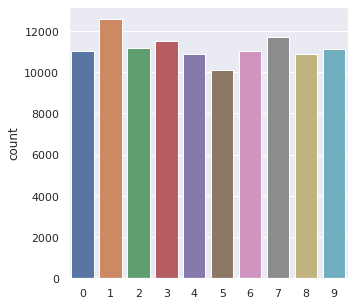

In [67]:
sns.set(style="darkgrid", rc = {'figure.figsize':(5,5)})

# Plot target distribution to check balanced/unbalanced problem
sns.countplot(Y_train)

### Pre-processing target variable

In [68]:
# Encoding the target
Y_train = keras.utils.to_categorical(Y_train, num_classes = len(np.unique(Y_train, return_counts=False)))

### Split data randomly

In [69]:
# Randomly split the dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_state)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

# Modeling

In [70]:
# Define model
# model = keras.Sequential()

# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())

# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(10, activation = "softmax"))

model = keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=192, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=192, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Build model
# model.build(X_train.shape)

# # Show model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 192)       221376    
                                                      

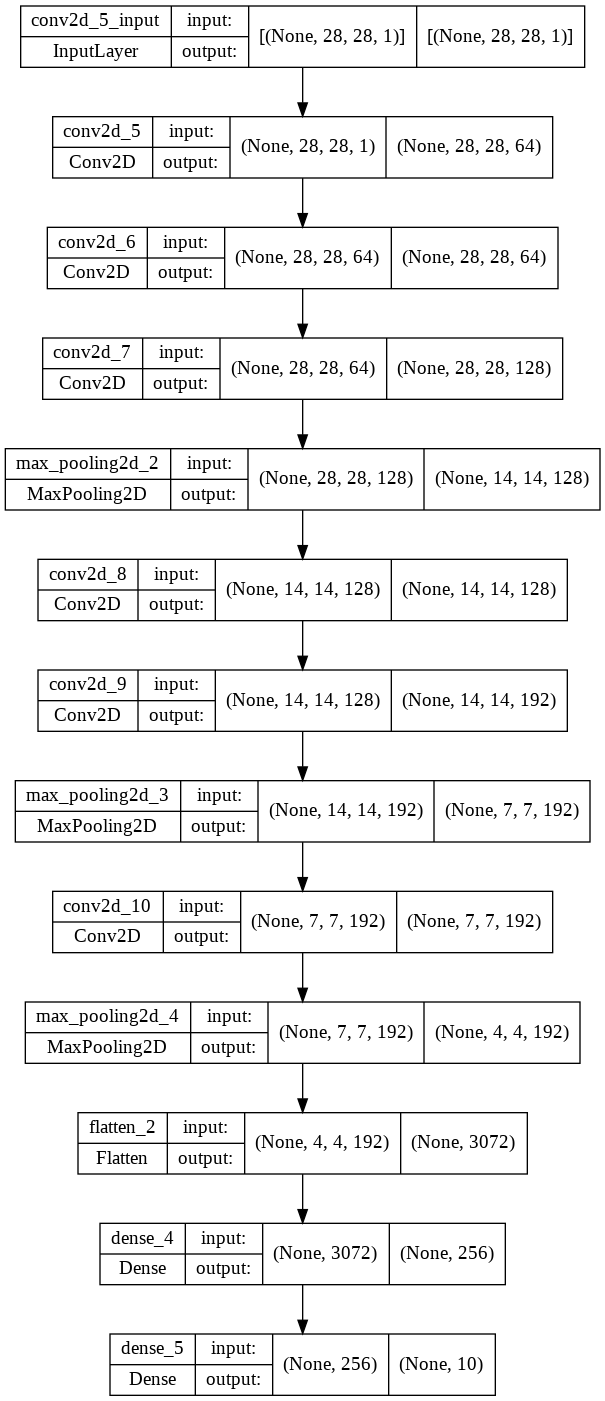

In [71]:
# Print model diagram
plot_model(model, to_file=output_path + '/model_simple.png', show_shapes=True, show_layer_names=True)
Image(output_path + '/model_simple.png')

In [72]:
# Define Optimizer
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

# Define early stopping to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.0001,
    restore_best_weights = True,
)

In [76]:
#Adjusting epochs and batch_size
epochs = 25
batch_size = 128
# batch_size = X_train.shape[0]

## Data Augmentation

In [77]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(X_train,Y_train, batch_size=batch_size)

## Train model

In [80]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",X_train.shape)
print("Y Train shape:",Y_train.shape)
print("X Validation shape:",X_val.shape)
print("Y Validation shape:",Y_val.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/history_model_simple.pkl','rb')
  history = pickle.load(infile)
  infile = open(models_path + '/model_simple.pkl','rb')
  model = pickle.load(infile)
else:
  #Prediction model
  history = model.fit(train_gen
                    , epochs = epochs
                    , validation_data = (X_val,Y_val)
                    , verbose = 2
                    , steps_per_epoch = X_train.shape[0] // batch_size
                    , callbacks=[early_stopping, learning_rate_reduction, GarbageCollectorCallback()]
                    , validation_steps = X_val.shape[0] // batch_size)
  #Save model
  with open(models_path + '/history_model_simple.pkl', 'wb') as pickfile:
     pickle.dump(history, pickfile)
  with open(models_path + '/model_simple.pkl', 'wb') as pickfile:
     pickle.dump(model, pickfile)
print("======================================================================================")
# print("Best parameters found: ")
# print(best_params)

print("======================================================================================")

# Evaluate the model
loss_and_metrics_train = model.evaluate(X_train, Y_train, verbose=2)
loss_and_metrics_val = model.evaluate(X_val, Y_val, verbose=2)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}".format(loss_and_metrics_train[1], loss_and_metrics_val[1]))

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (100800, 28, 28, 1)
Y Train shape: (100800, 10)
X Validation shape: (11200, 28, 28, 1)
Y Validation shape: (11200, 10)
Epoch 1/50
787/787 - 63s - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 63s/epoch - 80ms/step
Epoch 2/50
787/787 - 58s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 58s/epoch - 74ms/step
Epoch 3/50
787/787 - 58s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 58s/epoch - 74ms/step
Epoch 4/50
787/787 - 58s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 58s/epoch - 74ms/step
Epoch 5/50
787/787 - 58s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 58s/epoch - 74ms/step
Epoch 6/50
787/787 - 58s - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0081 - val_accuracy: 0.9977 - lr: 1.0000e-08 - 58s/epoch - 74ms/step
Epoch 7/50
787

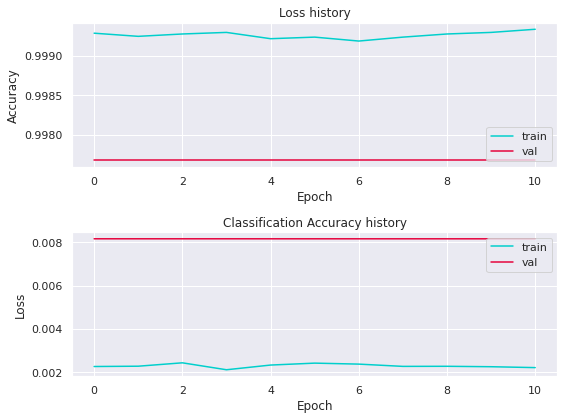

In [81]:
# Plot loss and accuracy
fig = plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], color = '#00cfcc')
plt.plot(history.history['val_accuracy'], color = '#e6013b')
plt.title('Loss history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'], color = '#00cfcc')
plt.plot(history.history['val_loss'], color = '#e6013b')
plt.title('Classification Accuracy history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()
plt.show()

### Confusion matrix

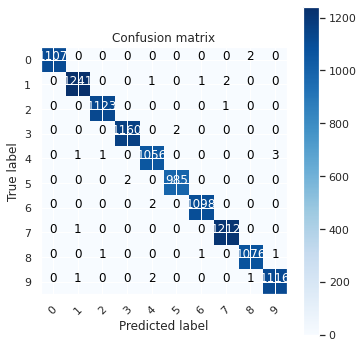

In [82]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [83]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

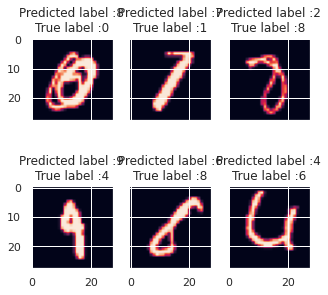

In [84]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predict target labels

In [85]:
# Predict the expected label
y_pred = np.argmax(model.predict(test), axis=-1)

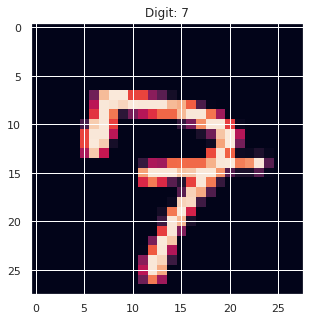

In [86]:
image_number = 5
# Predict selected number
plt.imshow(test[image_number].reshape(28, 28))

plt.title(f"Digit: {y_pred[image_number]}")
plt.show()

In [88]:
# Create submission file
submission = pd.DataFrame({'ImageId':pd.Series(list(range(1, len(y_pred)+1))),
                                   'Label':pd.Series(y_pred)})
submission.to_csv(submissions_path + '/Digit_recognizer_MINST_SIMPLE_Jimenez_v1.csv', index = False)

# Using pre-trained model (ResNet) - Transfer Learning

In [32]:
num_examples_train = train.shape[0]
# num_examples_val = X_val.shape[0]
num_examples_test = test.shape[0]
n_h = 32
n_w = 32
n_c = 3

In [33]:
del X_train, X_val, test, y_pred, model, history, train_gen, Y_pred_classes, confusion_mtx, x_train1, y_train1, x_test1, y_test1, train1, Y_train1
gc.collect()

0

In [35]:
start_time = time.time()

train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
Train_input_images = np.zeros((num_examples_train, n_h, n_w, n_c))
Test_input_images = np.zeros((num_examples_test, n_h, n_w, n_c))

for example in range(num_examples_train):
    Train_input_images[example,:28,:28,0] = train.iloc[example, 1:].values.reshape(28,28)
    Train_input_images[example,:28,:28,1] = train.iloc[example, 1:].values.reshape(28,28)
    Train_input_images[example,:28,:28,2] = train.iloc[example, 1:].values.reshape(28,28)
    
for example in range(num_examples_test):
    Test_input_images[example,:28,:28,0] = test.iloc[example, :].values.reshape(28,28)
    Test_input_images[example,:28,:28,1] = test.iloc[example, :].values.reshape(28,28)
    Test_input_images[example,:28,:28,2] = test.iloc[example, :].values.reshape(28,28)

for example in range(num_examples_train):
    Train_input_images[example] = cv2.resize(Train_input_images[example], (n_h, n_w))
    
for example in range(num_examples_test):
    Test_input_images[example] = cv2.resize(Test_input_images[example], (n_h, n_w))


print("Ejecución: %s seconds" % (time.time() - start_time))

Ejecución: 65.91787004470825 seconds


In [36]:
Train_labels = np.array(train.iloc[:, 0])

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(Train_input_images, 
                                                                      Train_labels,
                                                                      test_size = 0.1,
                                                                      random_state = random_state)
x_test = Test_input_images

In [38]:
del Train_labels, Train_input_images, Test_input_images
gc.collect()

66028

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=27,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=False)

validation_datagen = ImageDataGenerator()

In [40]:
# Load pretrained model
pretrained_model = keras.applications.resnet50.ResNet50(input_shape=(n_h, n_w, n_c),
                                                        include_top=False, weights='imagenet')
# Define pretrained + desired mode
model_RESNET50 = keras.Sequential([
    pretrained_model,
    keras.layers.Flatten(),
    keras.layers.Dense(units=60, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])

94781440/94765736 [==============================] - 2s 0us/step


In [41]:
Optimizer = 'RMSprop'

model_RESNET50.compile(optimizer=Optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [42]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.999999):
            print("Stop training!")
            self.model.stop_training = True

In [45]:
callbacks = myCallback()

In [47]:
EPOCHS = 50
batch_size = 128

In [48]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",X_train.shape)
print("Y Train shape:",Y_train.shape)
print("X Validation shape:",X_val.shape)
print("Y Validation shape:",Y_val.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/history_model_RESNET50.pkl','rb')
  history_RESNET50 = pickle.load(infile)
  infile = open(models_path + '/model_RESNET50.pkl','rb')
  model_RESNET50 = pickle.load(infile)
else:
  #Prediction model
  history_RESNET50 = model_RESNET50.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] / batch_size, 
                          epochs=EPOCHS,   
                          validation_data=validation_datagen.flow(X_val,Y_val,
                                                                  batch_size=batch_size),
                          validation_steps=X_val.shape[0] / batch_size,
                          callbacks=[callbacks, GarbageCollectorCallback()]
                          , verbose = 2)
  #Save model
  with open(models_path + '/history_model_RESNET50.pkl', 'wb') as pickfile:
     pickle.dump(history_RESNET50, pickfile)
  with open(models_path + '/model_RESNET50.pkl', 'wb') as pickfile:
     pickle.dump(model_RESNET50, pickfile)
print("======================================================================================")
# print("Best parameters found: ")
# print(best_params)

print("======================================================================================")

# Evaluate the model
loss_and_metrics_train_RESNET50 = model_RESNET50.evaluate(X_train, Y_train, verbose=2)
loss_and_metrics_val_RESNET50 = model_RESNET50.evaluate(X_val, Y_val, verbose=2)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}".format(loss_and_metrics_train_RESNET50[1], loss_and_metrics_val_RESNET50[1]))

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (37800, 32, 32, 3)
Y Train shape: (37800,)
X Validation shape: (4200, 32, 32, 3)
Y Validation shape: (4200,)
Epoch 1/25
295/295 - 83s - loss: 0.5445 - accuracy: 0.8564 - val_loss: 177.2874 - val_accuracy: 0.2355 - 83s/epoch - 281ms/step
Epoch 2/25
295/295 - 69s - loss: 0.2289 - accuracy: 0.9454 - val_loss: 2.0692 - val_accuracy: 0.9407 - 69s/epoch - 233ms/step
Epoch 3/25
295/295 - 58s - loss: 0.1765 - accuracy: 0.9574 - val_loss: 67.1174 - val_accuracy: 0.5919 - 58s/epoch - 196ms/step
Epoch 4/25
295/295 - 58s - loss: 0.1665 - accuracy: 0.9612 - val_loss: 0.4898 - val_accuracy: 0.9400 - 58s/epoch - 196ms/step
Epoch 5/25
295/295 - 59s - loss: 0.1436 - accuracy: 0.9663 - val_loss: 1.2930 - val_accuracy: 0.9110 - 59s/epoch - 199ms/step
Epoch 6/25
295/295 - 63s - loss: 0.1368 - accuracy: 0.9691 - val_loss: 4.6493 - val_accuracy: 0.8450 - 63s/epoch - 214ms/step
Epoch 7/25
295/295 - 58s - loss: 0.1509 - accuracy: 0.9697 - val_loss: 1.5214 - val_accuracy: 0.9488 - 58s/epoch - 19

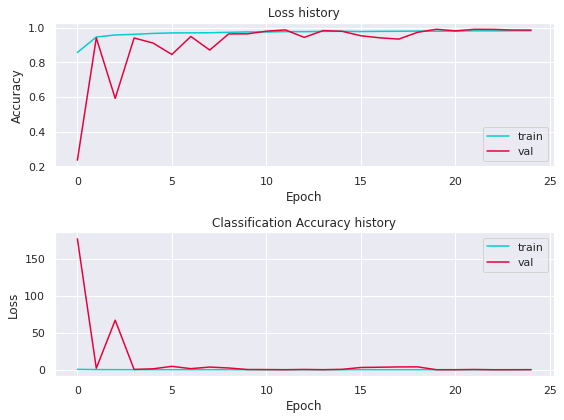

In [49]:
# Plot loss and accuracy
fig = plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(history_RESNET50.history['accuracy'], color = '#00cfcc')
plt.plot(history_RESNET50.history['val_accuracy'], color = '#e6013b')
plt.title('Loss history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history_RESNET50.history['loss'], color = '#00cfcc')
plt.plot(history_RESNET50.history['val_loss'], color = '#e6013b')
plt.title('Classification Accuracy history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()
plt.show()

In [50]:
# Predict the expected label
y_pred_RESNET50 = model_RESNET50.predict(x_test)

In [ ]:
# Create submission file
submission = pd.DataFrame({'ImageId':pd.Series(list(range(1, len(y_pred_RESNET50)+1))),
                                   'Label':pd.Series(y_pred_RESNET50)})
submission.to_csv(submissions_path + '/Digit_recognizer_MINST_RESNET50_Jimenez_v1.csv', index = False)

# References

- https://www.kaggle.com/raghaw/mnist-cnn-external-data-perfect-score
- https://www.kaggle.com/jrreda/simple-mlp-digit-recognizer-with-keras-97
- https://www.kaggle.com/ahmed121ashraf131/mnist-simple-cnn-knn-accuracy-100-top-1
- https://www.kaggle.com/pybear/cnn-100-transfer-learning-data-augmentation